<a href="https://colab.research.google.com/github/zmarquis13/cortical_model_MNIST/blob/main/MNIST_cortical_partial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [ ]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17809783.73it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 680052.40it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 5391524.19it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1244075.54it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
lr = 0.1
batch_size = 64
epochs = 10

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


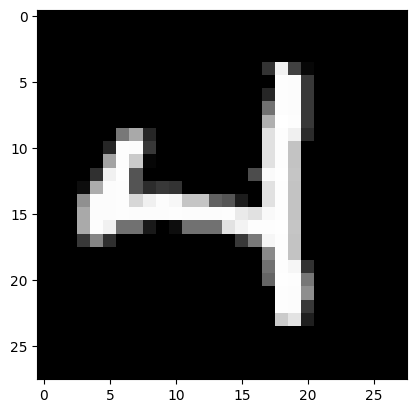

Label: 4


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        #can't do sequential because I want parallel computation
        #self.input = nn.Linear(28*28, 512)
        self.input = nn.Linear(28*28, 512)
        self.hidden = nn.Linear(512, 512)

        #cortex hidden layers
        self.cortex1 = nn.Linear(512, 10)
        self.cortex2 = nn.Linear(512, 10)
        self.cortex3 = nn.Linear(512, 10)
        self.cortex4 = nn.Linear(512, 10)
        self.cortex5 = nn.Linear(512, 10)
        #self.cortex6 = nn.Linear(512, 10)
        #self.cortex7 = nn.Linear(512, 10)
        #self.cortex8 = nn.Linear(512, 10)
        #self.cortex9 = nn.Linear(512, 10)
        #self.cortex10 = nn.Linear(512, 10)

        #outputs
        self.output1 = nn.Linear(10, 1)
        self.output2 = nn.Linear(10, 1)
        self.output3 = nn.Linear(10, 1)
        self.output4 = nn.Linear(10, 1)
        self.output5 = nn.Linear(10, 1)
        self.output6 = nn.Linear(10, 1)
        #self.output7 = nn.Linear(10, 1)
        #self.output8 = nn.Linear(10, 1)
        #self.output9 = nn.Linear(10, 1)
        #self.output10 = nn.Linear(10, 1)

    def forward(self, x):
        #print(x.shape)
        x = self.input(x)

        #print(x.shape)

        x = self.hidden(x)

        #print(x.shape)

        #print("break")

        x1 = torch.relu(self.cortex1(x))
        x2 = torch.relu(self.cortex2(x))
        x3 = torch.relu(self.cortex3(x))
        x4 = torch.relu(self.cortex4(x))
        x5 = torch.relu(self.cortex5(x))
        #x6 = torch.relu(self.cortex6(x))
        #x7 = torch.relu(self.cortex7(x))
        #x8 = torch.relu(self.cortex8(x))
        #x9 = torch.relu(self.cortex9(x))
        #x10 = torch.relu(self.cortex10(x))

        #cortices have shape ([64, 10])
        #print(x1.shape)

        x1 = self.output1(x1)
        x2 = self.output2(x2)
        x3 = self.output3(x3)
        x4 = self.output4(x4)
        x5 = self.output5(x5)
        #x6 = self.output6(x6)
        #x7 = self.output7(x7)
        #x8 = self.output8(x8)
        #x9 = self.output9(x9)
        #x10 = self.output10(x10)

        #outputs have shape ([64, 1])
        #print(x1)

        #add x6-x10 to make complete
        x = torch.cat((x1, x2, x3, x4, x5), 1)

        #concatenating gives shape ([64, 5])
        #print(x.shape)

        #basically want each value to be 1 - the sum of the five predicted vales in x
        temp = torch.ones(x.size(0), 1)
        for i in range (x.size(0)):
          sum = 0
          for j in range(5):
            sum += x[1][j]
            temp[i] = 1 - torch.sigmoid(sum)

        zeros = torch.zeros(x.size(0), 4)
        intermediate = torch.cat((temp, zeros), 1)

        x = torch.cat((x, intermediate), 1)

        #print(x)

        #x = torch.cat((x, ones), 1)

        return x

model = NeuralNetwork()

In [ ]:
#may need to define a more complicated loss function because the output is 1x5 and the ground truth is 1x10
#if I can "cut" the ground truth to its first 5 values (or extend output to 1x10 with zeros), then I can get an actual loss function
#extending the output seems easier because then I can use the default cross entropy loss

#also something to consider: data will be 50% "null" and 10% of each of the numbers, may cause bias
#towards null but this is solvable by only including 1/6 of the null values
#or I could make 10 cortices and include 1/11th static

loss_fn = nn.CrossEntropyLoss()


In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices

    #y is a 1x64 tensor

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss

        #print(y)

        #print("break")

        X = X.view(X.shape[0],784)
        #print(len(X))


        pred = model(X)

        #program break
        #if y > 6:
        #  y = 6

        for i in range(y.size(0)):
              if y[i] > 5:
                y[i] = 5

        #pred = torch.cat(pred, ([0.5]))

        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 99:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    #size = 10000
    num_batches = len(dataloader)
    #num batches = 10000/64
    #print (num_batches)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True

    # Need some way to make a null prediction actually count
    # Basically, want output to not be argmaxed (or argmaxed with some kind of default value added on)
    # Ex. if output is 0.3, 0.1, 0.0. 0.2, 0.1, could add 0.5 on the end and make it represent the null before argmaxing
    # Main issue: outputs may not be scaled 0 to 1
    # Also, then how to train

    with torch.no_grad():
        for X, y in dataloader:
            X = X.view(X.shape[0],784)

            pred = model(X)

            #how is this actually calculating whether or not it's correct?
            #note: any changes here will also probably have to be made to train

            #y is a 1x64 tensor of the 64 ground truths for the batch
            #could iterate through y and make every value above 6 equal to 6

            for i in range(y.size(0)):
              if y[i] > 5:
                y[i] = 5

            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Number Test Results: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
def test_static(mode, loss_fn):
  model.eval()
  #size of about 10000

  with torch.no_grad():
    size = 157*64
    num_batches = 157
    test_loss, correct = 0, 0

    for i in range (num_batches):
      #figure out how to set all the labels to 6
      static = torch.rand(64, 784)
      pred = model(static)

      #long to resolve runtime error
      y = torch.ones(64, dtype=torch.long)
      y = y * 5

      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  #fixed size to try to resolve error
  correct /= 10048.0
  print(f"Static Test Results: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")



In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
    test_static(model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.964890  [ 6400/60000]
loss: 0.718468  [12800/60000]
loss: 0.632759  [19200/60000]
loss: 0.750583  [25600/60000]
loss: 0.815116  [32000/60000]
loss: 0.719433  [38400/60000]
loss: 0.809382  [44800/60000]
loss: 0.580018  [51200/60000]
loss: 0.799470  [57600/60000]
Number Test Results: 
 Accuracy: 91.8%, Avg loss: 0.694228 

Static Test Results: 
 Accuracy: 99.7%, Avg loss: 0.932873 

Epoch 2
-------------------------------
loss: 0.835070  [ 6400/60000]
loss: 0.743100  [12800/60000]
loss: 0.726761  [19200/60000]
loss: 0.561136  [25600/60000]
loss: 0.698230  [32000/60000]
loss: 0.690678  [38400/60000]
loss: 0.907619  [44800/60000]
loss: 0.586817  [51200/60000]
loss: 0.615545  [57600/60000]
Number Test Results: 
 Accuracy: 91.7%, Avg loss: 0.651008 

Static Test Results: 
 Accuracy: 98.8%, Avg loss: 0.947946 

Epoch 3
-------------------------------
loss: 0.721680  [ 6400/60000]
loss: 0.789012  [12800/60000]
loss: 0.705962  [19200/60000]
loss: 